# Evaluating synthetic training data

### This notebook contains functions for observing Barts zero shot classifier on synthetic data. The purpose of this notebook is to show what labels bart is most confident in. Given 80 examples of entailment for each premise and hypothesis, we want to see how confident Bart is in each of those 80 entailment examples

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy
import torch 
from transformers import BartForSequenceClassification, BartTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import torch

In [58]:
def return_high_conf(data):
    LABELS = ["contradiction", "neutral", "entailment"]
    high_conf_list = []

    high_conf_dict = {
        "97-100": [],
        "95-97": [],
        "90-95": [],
        "80-90": [],
        "60-80": [],
        "40-60": [],
        "0-40": []
    }
    
    for _, row in data.iterrows():
        premise = row["premise"]
        hypothesis = row["hypothesis"]
        
        inputs = tokenizer(
            premise,
            hypothesis,
            return_tensors="pt",
            truncation=True,
            padding=True
        )

        scores = torch.softmax(model(**inputs).logits, dim=-1)
        scores = scores.squeeze().tolist()

        if scores[2] > .97:
            high_conf_dict["97-100"].append(premise)
        elif scores[2] >= .95 and scores[2] < .97:
            high_conf_dict["95-97"].append(premise)
        elif scores[2] >= .90 and scores[2] < .95:
            high_conf_dict["90-95"].append(premise)
        elif scores[2] >= .80 and scores[2] < .90:
            high_conf_dict["80-90"].append(premise)
        elif scores[2] >= .60 and scores[2] < .80:
            high_conf_dict["60-80"].append(premise)
        elif scores[2] >= .40 and scores[2] < .60:
            high_conf_dict["40-60"].append(premise)
        elif scores[2] < .40:
            high_conf_dict["0-40"].append(premise)
    
    return high_conf_dict

def value_to_num(score_dict):
    for key in score_dict.keys():
        new_val = len(score_dict[key])
        score_dict[key] = new_val

    return score_dict

def graph_score_distribution(len_score_dict, data_name=""):
    keys = list(len_score_dict.keys())
    values = list(len_score_dict.values())

    plt.figure()
    for i in range(len(keys)):
        plt.bar(keys[i], values[i])

    plt.title("confidence scores from current bart model - " + data_name)
    plt.xlabel("confidence level")
    plt.ylabel("text count")
    plt.show()

    return 
    
def get_unique_labeled_text(df):
    new_df = pd.DataFrame(columns=df.columns)
    count = 0
    
    for num in range(len(df['label'])):     
        if df['label'][num] == "entailment":            
            new_df.loc[count, 'premise'] = df.loc[num, 'premise']
            new_df.loc[count, 'hypothesis'] = df.loc[num, 'hypothesis']
            new_df.loc[count, 'label'] = df.loc[num, 'label']
            
            count += 1

    return new_df

In [59]:
claude_data = pd.read_csv("CLAUDE_training.csv")
unique_claude_data = get_unique_labeled_text(claude_data)
unique_claude_data

,premise,hypothesis,label
0,Just wanted to say thanks to all the firefight...,This text expresses gratitude.,entailment
1,Our community center is finally reopening afte...,This text expresses gratitude.,entailment
2,Shoutout to my neighbor who let us stay at his...,This text expresses gratitude.,entailment
3,I'm amazed at how quickly the forest is recove...,This text expresses gratitude.,entailment
4,My insurance company actually came through wit...,This text expresses gratitude.,entailment
...,...,...,...
635,DIY versus hiring professionals for this type ...,This text is seeking help or advice.,entailment
636,Timing could be better but circumstances aren'...,This text is seeking help or advice.,entailment
637,Expectations weren't managed well from the beg...,This text is seeking help or advice.,entailment
638,Research shows mixed results for different app...,This text is seeking help or advice.,entailment


In [42]:
model_name = 'facebook/bart-large-mnli'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForSequenceClassification.from_pretrained(model_name, num_labels=3)

/Users/joeycartwright/miniconda3/envs/csci477/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [61]:
conf_score_dict = return_high_conf(unique_claude_data)
len_score_dict = value_to_num(conf_score_dict.copy())

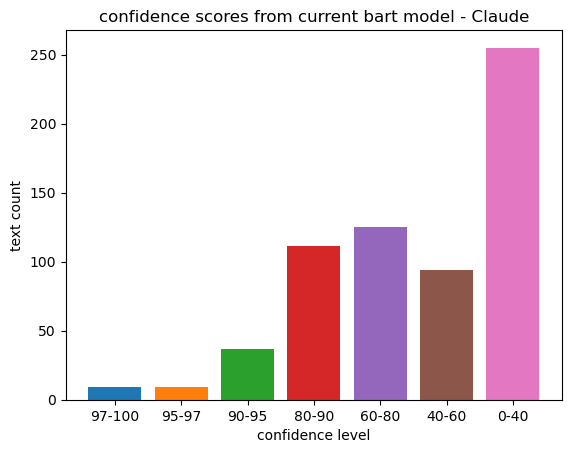

In [64]:
graph_score_distribution(len_score_dict, data_name="Claude")

In [65]:
gemini_data = pd.read_csv("GEMINI_training.csv")
unique_gemini_data = get_unique_labeled_text(gemini_data)

gpt_data = pd.read_csv("GPT_training.csv")
unique_gpt_data = get_unique_labeled_text(gpt_data)

In [66]:
conf_score_dict_gemini = return_high_conf(unique_gemini_data)
len_score_dict_gemini = value_to_num(conf_score_dict_gemini.copy())

conf_score_dict_gpt = return_high_conf(unique_gpt_data)
len_score_dict_gpt = value_to_num(conf_score_dict_gpt.copy())

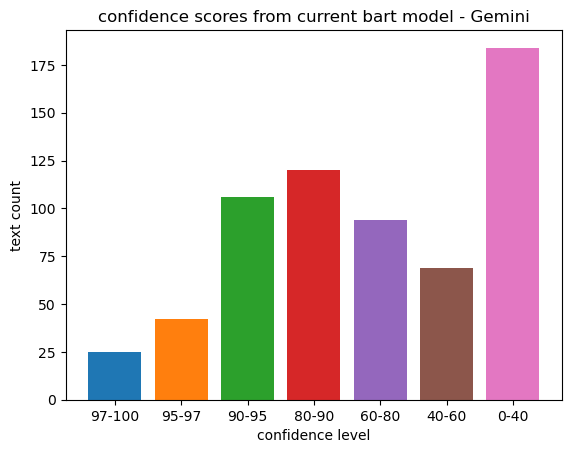

In [67]:
graph_score_distribution(len_score_dict_gemini, data_name="Gemini")

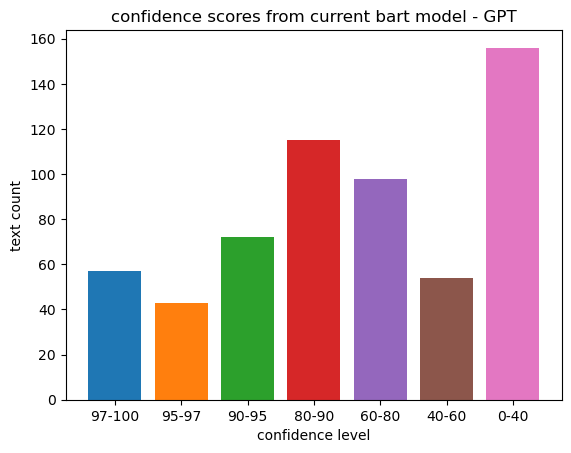

In [68]:
graph_score_distribution(len_score_dict_gpt, data_name="GPT")

In [87]:
def create_word_clouds(score_text_list, data_name=""):
    fig_name = str(data_name + ".png")
    full_string_words = ' '.join(score_text_list)

    wordcloud = WordCloud(width=350,
                          height=150,
                          background_color='white',
                          colormap="coolwarm").generate(full_string_words)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(data_name + " - Word Cloud")
    plt.axis('off')
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.show()

    return 

def iterate_word_cloud(score_dict):
    for key in score_dict.keys():
        create_word_clouds(score_dict[key], data_name=key)

    return 

## Word Clouds - GEMINI

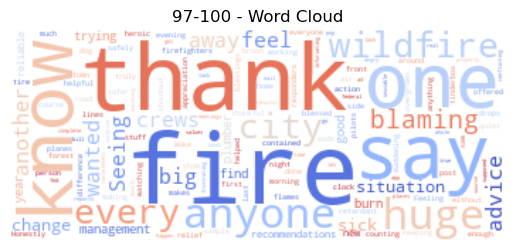

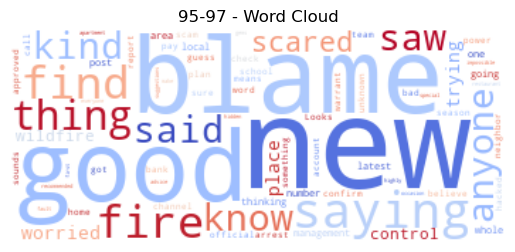

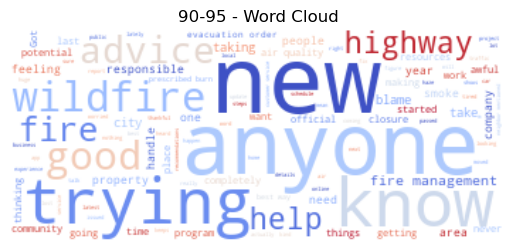

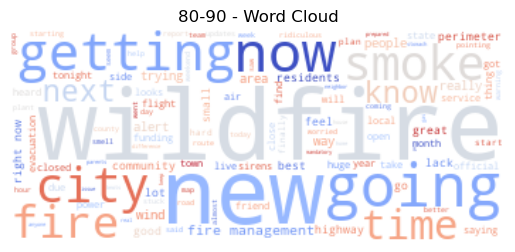

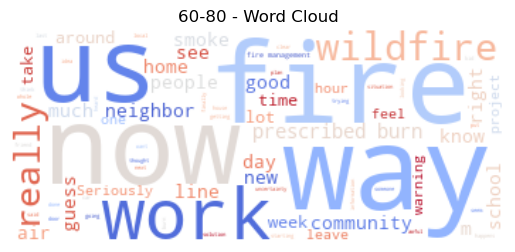

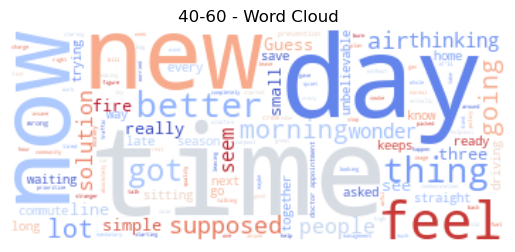

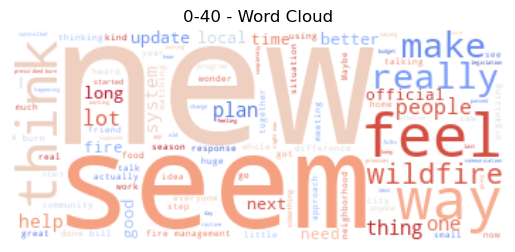

In [89]:
iterate_word_cloud(conf_score_dict_gemini)

## Word Clouds - GPT

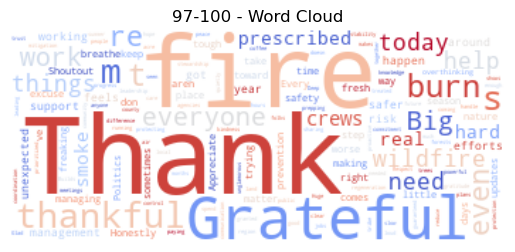

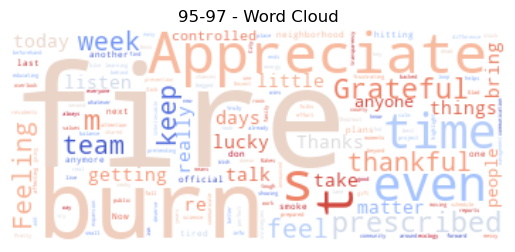

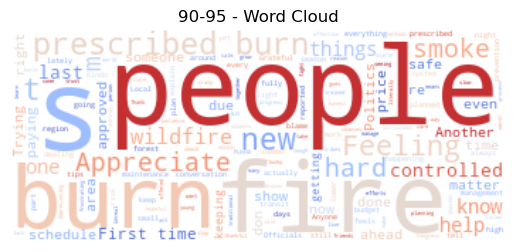

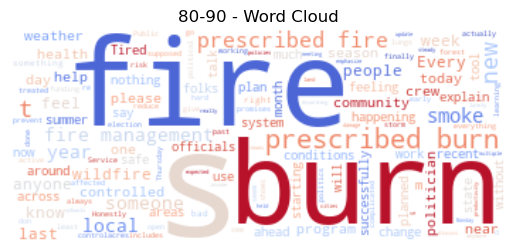

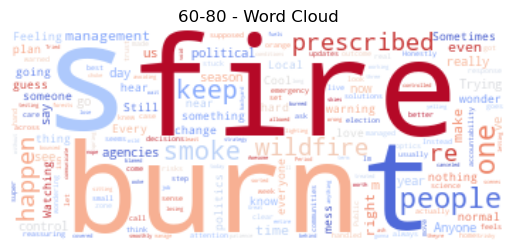

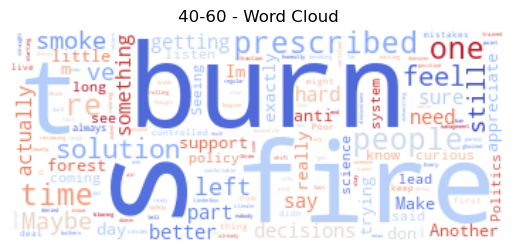

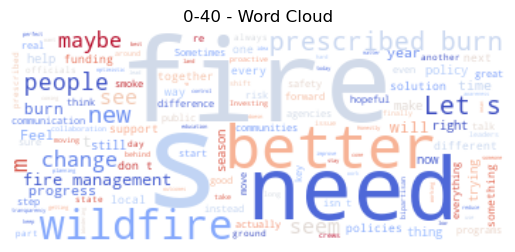

In [90]:
iterate_word_cloud(conf_score_dict_gpt)

## Word Clouds - CLAUDE

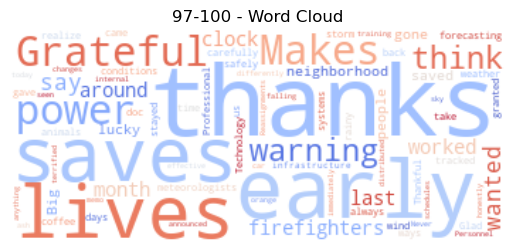

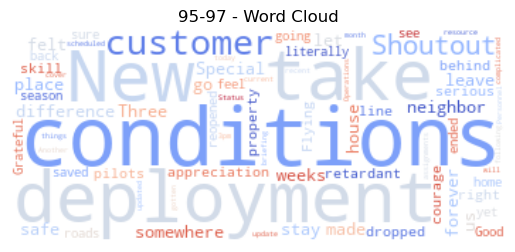

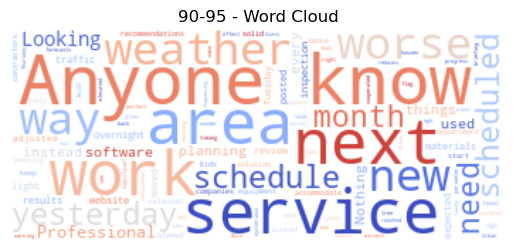

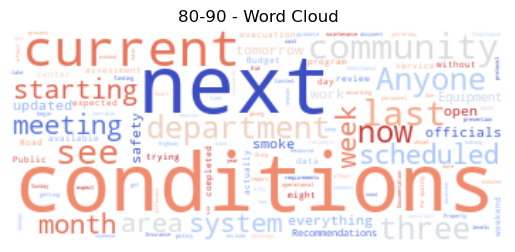

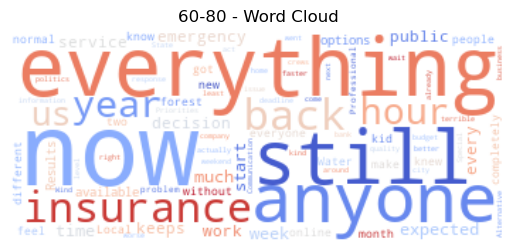

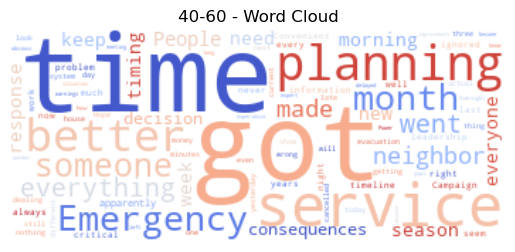

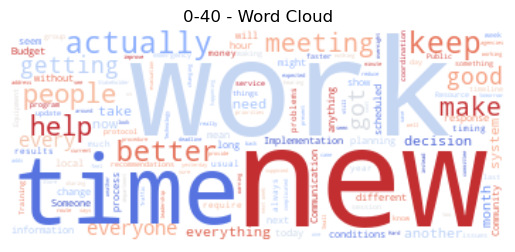

In [94]:
iterate_word_cloud(conf_score_dict)

In [99]:
def bin_conf_labels(data):
    LABELS = ["contradiction", "neutral", "entailment"]
    high_conf_list = []

    high_conf_dict = {
        "97-100": {},
        "95-97": {},
        "90-95": {},
        "80-90": {},
        "60-80": {},
        "40-60": {},
        "0-40": {}
    }
    
    for _, row in data.iterrows():
        premise = row["premise"]
        hypothesis = row["hypothesis"]
        
        inputs = tokenizer(
            premise,
            hypothesis,
            return_tensors="pt",
            truncation=True,
            padding=True
        )

        scores = torch.softmax(model(**inputs).logits, dim=-1)
        scores = scores.squeeze().tolist()

        if scores[2] > .97:
            if hypothesis not in high_conf_dict["97-100"]:
                high_conf_dict["97-100"][hypothesis] = 0
            
            high_conf_dict["97-100"][hypothesis] += 1
        elif scores[2] >= .95 and scores[2] < .97:
            if hypothesis not in high_conf_dict["95-97"]:
                high_conf_dict["95-97"][hypothesis] = 0
            
            high_conf_dict["95-97"][hypothesis] += 1
        elif scores[2] >= .90 and scores[2] < .95:
            if hypothesis not in high_conf_dict["90-95"]:
                high_conf_dict["90-95"][hypothesis] = 0
            
            high_conf_dict["90-95"][hypothesis] += 1
        elif scores[2] >= .80 and scores[2] < .90:
            if hypothesis not in high_conf_dict["80-90"]:
                high_conf_dict["80-90"][hypothesis] = 0
            
            high_conf_dict["80-90"][hypothesis] += 1
        elif scores[2] >= .60 and scores[2] < .80:
            if hypothesis not in high_conf_dict["60-80"]:
                high_conf_dict["60-80"][hypothesis] = 0
            
            high_conf_dict["60-80"][hypothesis] += 1
        elif scores[2] >= .40 and scores[2] < .60:
            if hypothesis not in high_conf_dict["60-80"]:
                high_conf_dict["60-80"][hypothesis] = 0
            
            high_conf_dict["60-80"][hypothesis] += 1
        elif scores[2] < .40:
            if hypothesis not in high_conf_dict["0-40"]:
                high_conf_dict["0-40"][hypothesis] = 0
            
            high_conf_dict["0-40"][hypothesis] += 1
    
    return high_conf_dict

## Confidence Scores with Hypothesis Counts - GPT

In [100]:
bin_conf_labels(unique_gpt_data)

{'97-100': {'This text expresses gratitude.': 43,
  'This text expresses frustration.': 4,
  'This text is political in nature.': 2,
  'This text provides information or news.': 1,
  'This text expresses fear or panic.': 2,
  'This text contains blaming.': 1,
  'This text is seeking help or advice.': 4},
 '95-97': {'This text expresses gratitude.': 20,
  'This text expresses frustration.': 9,
  'This text provides information or news.': 3,
  'This text expresses fear or panic.': 5,
  'This text contains blaming.': 2,
  'This text is seeking help or advice.': 4},
 '90-95': {'This text expresses gratitude.': 12,
  'This text expresses frustration.': 12,
  'This text is political in nature.': 3,
  'This text provides information or news.': 21,
  'This text expresses fear or panic.': 3,
  'This text contains blaming.': 7,
  'This text is seeking help or advice.': 14},
 '80-90': {'This text expresses gratitude.': 2,
  'This text expresses frustration.': 20,
  'This text is political in natu

## Confidence Scores with Hypothesis Counts - GEMINI

In [101]:
bin_conf_labels(unique_gemini_data)

{'97-100': {'This text expresses gratitude.': 9,
  'This text expresses frustration.': 7,
  'This text provides information or news.': 2,
  'This text contains blaming.': 4,
  'This text is seeking help or advice.': 3},
 '95-97': {'This text expresses gratitude.': 2,
  'This text expresses frustration.': 2,
  'This text provides information or news.': 16,
  'This text expresses fear or panic.': 7,
  'This text contains blaming.': 9,
  'This text is seeking help or advice.': 6},
 '90-95': {'This text expresses gratitude.': 10,
  'This text expresses frustration.': 9,
  'This text is political in nature.': 2,
  'This text provides information or news.': 25,
  'This text expresses fear or panic.': 8,
  'This text contains blaming.': 16,
  'This text is seeking help or advice.': 36},
 '80-90': {'This text expresses gratitude.': 17,
  'This text expresses frustration.': 13,
  'This text is political in nature.': 2,
  'This text is focused on solutions.': 1,
  'This text provides information

## Confidence Scores with Hypothesis Counts - CLAUDE

In [102]:
bin_conf_labels(unique_claude_data)

{'97-100': {'This text expresses gratitude.': 7,
  'This text provides information or news.': 1,
  'This text expresses fear or panic.': 1},
 '95-97': {'This text expresses gratitude.': 4,
  'This text provides information or news.': 2,
  'This text expresses fear or panic.': 1,
  'This text contains blaming.': 1,
  'This text is seeking help or advice.': 1},
 '90-95': {'This text expresses gratitude.': 2,
  'This text expresses frustration.': 2,
  'This text provides information or news.': 15,
  'This text expresses fear or panic.': 3,
  'This text contains blaming.': 4,
  'This text is seeking help or advice.': 11},
 '80-90': {'This text expresses gratitude.': 9,
  'This text expresses frustration.': 6,
  'This text is political in nature.': 4,
  'This text provides information or news.': 48,
  'This text expresses fear or panic.': 6,
  'This text contains blaming.': 7,
  'This text is seeking help or advice.': 31},
 '60-80': {'This text expresses gratitude.': 46,
  'This text expres